In [1]:
%matplotlib inline


# Empirical evaluation of the impact of repetitions (`n_init`) for the ``KMeans`` and ``MiniBatchKMeans`` class


This notebook is a modified version of a [scikit-learn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html). It was created to contribute to [scikit-learn issue #25022](https://github.com/scikit-learn/scikit-learn/issues/25022)

Evaluate the effect of the number of runs (parameter `n_init`) on the mean inertia (i.e. the sum of squared
distances to the nearest cluster center) of the result.

The first plot shows the best inertia reached for 
the models``KMeans`` , ``MiniBatchKMeans``, and -- to demonstrate obtainable inertia levels -- ``BKMeans`` (class name for [*Breathing K-Means*](https://pypi.org/project/bkmeans/)). 

The init method
is set to ``init="kmeans++"`` for increasing values of the
``n_init`` parameter that controls the number of initializations. 

The other plots show the last obtained solution of each method (the one with highest value for `n_init`, i.e., `n_init=20`).

The dataset used for evaluation is a 2D grid of $4\times4=16$ isotropic Gaussian clusters widely spaced. All clusters are identical (apart from their position in the plane).
 The value of $k$ (or `n_clusters`) was intentionally set to be $32$, i.e., 2 times the number of clusters in the data set. This makes the problem more difficult. For symmetry reasons an optimal solution (lowest SSE) needs to position two centroids in each cluster. This is not sufficient, however, for the actual optimum, since in each cluster the respective two centroids also would have to be positioned optimally. (side note: for the the planar $k$-means problem with $k=2$ [polynomial algorithms exist](https://dl.acm.org/doi/10.1145/177424.178042))

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/gittar/skl-discussion/HEAD)

In [2]:
!pip install bkmeans

## Statistics

Evaluation of KMeans with k-means++ init
Evaluation of MiniBatchKMeans with k-means++ init
Evaluation of BKMeans with k-means++ init


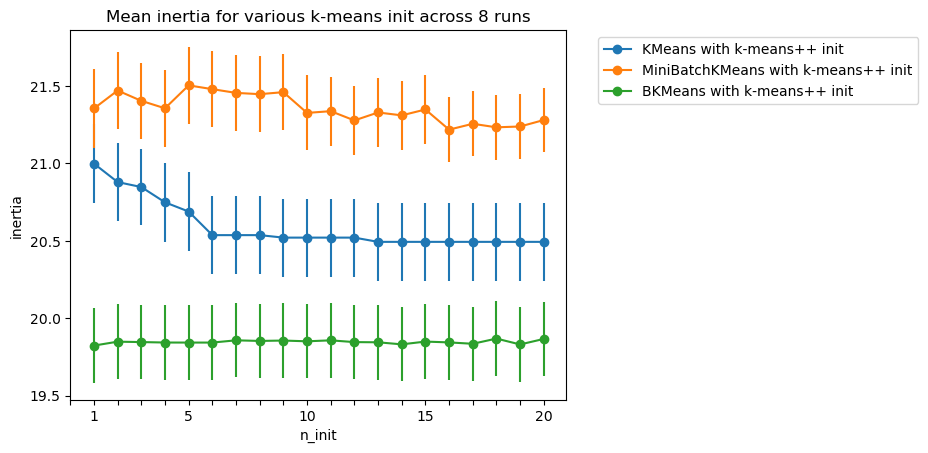

In [3]:
# adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html
# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

# Author of this notebook:
# Bernd Fritzke <fritzke@web.de>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from bkmeans import BKMeans 

random_state = np.random.RandomState(4)

# Number of run (with randomly generated dataset) for each strategy so as
# to be able to compute an estimate of the standard deviation
n_runs = 8

# k-means models can do several random inits so as to be able to trade
# CPU time for convergence robustness
n_init_range = np.arange(1,21,1)

# Datasets generation parameters
n_samples_per_center = 100
grid_size = 4
scale = 0.1
n_clusters = grid_size**2*2


def make_data(random_state, n_samples_per_center, grid_size, scale):
    random_state = check_random_state(random_state)

    centers = np.array([[i, j] for i in range(grid_size) for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape

    noise = random_state.normal(
        scale=scale, size=(n_samples_per_center, centers.shape[1])
    )

    X = np.concatenate([c + noise for c in centers])
    y = np.concatenate([[i] * n_samples_per_center for i in range(n_clusters_true)])
    return shuffle(X, y, random_state=random_state)


# Part 1: Quantitative evaluation of various init methods


plt.figure()
plots = []
legends = []

# random init omitted since huge SSE values dominated the vertical scaling
cases = [
    (KMeans, "k-means++", {}),
    #(KMeans, "random", {}),
    (MiniBatchKMeans, "k-means++", {"max_no_improvement": 3}),
    #(MiniBatchKMeans, "random", {"max_no_improvement": 3, "init_size": 500}),
    (BKMeans, "k-means++", {"m":10}),

]
kms={}
for factory, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))
    
        
    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        for i, n_init in enumerate(n_init_range):
            km = factory(
                n_clusters=n_clusters,
                init=init,
                random_state=run_id,
                n_init=n_init, #if factory!=BKMeans else 1, # BKMeans only needs 1 trial
                **params,
            )
            km.fit(X)
            inertia[i, run_id] = km.inertia_
    kms[factory.__name__+", "+init]=km
    # std scaled down to not dominate the vertical plot scaling
    p = plt.errorbar(n_init_range, inertia.mean(axis=1), 0.1*inertia.std(axis=1),marker="o")
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))

plt.xlabel("n_init")
plt.ylabel("inertia")
plt.xticks([1,5,10,15,20])
plt.legend(plots, legends, bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.title("Mean inertia for various k-means init across %d runs" % n_runs)
# show ticks at integer positions and only selected labels
plt.xticks(range(0,21))
for i, label in enumerate(plt.gca().get_xticklabels()):
    if not i in [1,5,10,15,20]:
        label.set_visible(False)

Interpretation (just based on this example):
* `MiniBatchKMeans`: apparently no clear dependency relation on `n_init`, high SSE, not gonna analyze this one
* `KMeans`: the mean SSE drops with `n_init` initially (until `n_init=6`) and then stays about the same (saturation), but significantly above obtainable better values (see results for `BKMeans`)
* `BKMeans`: the mean SSE seems to be always about the same, independent from `n_init`(therefore `n_init=1` seems sufficient), low SSE

Conclusions (for this example):
* for `KMeans` with `k-means++` initialization larger values of `n_init` lead to better results, even if the effect nearly vanishes from a certain value of `n_init` and near-optimal results are not achieved.

## sample solutions (obtained with `n_init=20`)

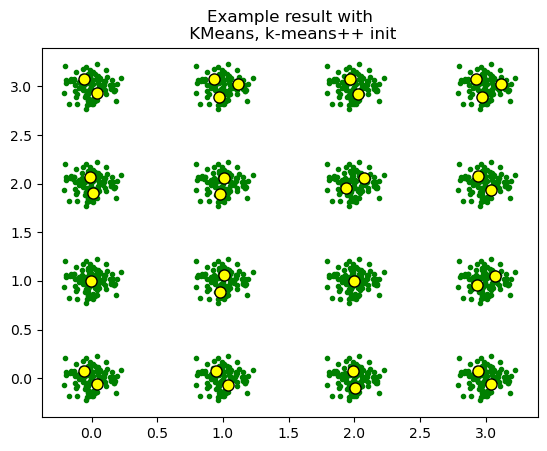

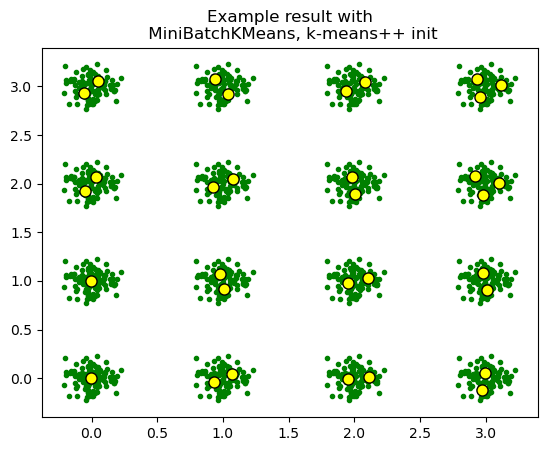

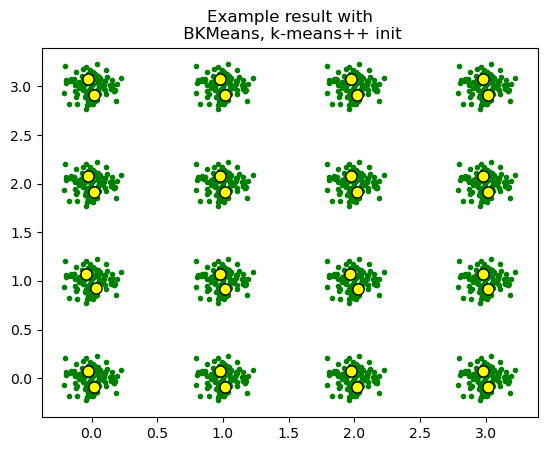

In [8]:
for kmname, km in kms.items():
    plt.figure()
    for k in range(n_clusters):
        my_members = km.labels_ == k
        color = cm.nipy_spectral(float(k) / n_clusters, 1)
        plt.plot(X[my_members, 0], X[my_members, 1], ".", c="green")
        cluster_center = km.cluster_centers_[k]
        plt.plot(
            cluster_center[0],
            cluster_center[1],
            marker="o",
            markerfacecolor="yellow",
            markeredgecolor="k",
            markersize=8,
            zorder= 5
        )
        plt.title(
            f"Example result with\n {kmname} init"
        )

    plt.show()